# Solution of Programming Exercise 4 - Group N

Authors:  Jairo R. Mejia and Pablo Gomez Hidalgo

Problem 1 (20 pts)


We first generate the requested dataset from the two given distributions.

In [13]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

mu1 = np.array([1, 1])
mu2 = np.array([-1,-1])
sigma1 = np.array([[1, 0.6],[0.6, 1]])
sigma2 = np.array([[1, -0.9], [-0.9, 1]])

A = multivariate_normal.rvs(mean = mu1, cov = sigma1, size=50)
B = multivariate_normal.rvs(mean = mu2, cov = sigma2, size=50)
C = np.concatenate((A,B), 0, dtype = float)

Let's implement the Gaussian Mixture algorithm. 

**Remark:**
During the development of the algorithm, we noticed that there were some cases where the algorithm does not deliver a good result. We tried to solved this with the next changes:

- The chosen epsilon is smaller than the one in the requirements. This will help that the stop condition of the algorithm does not stop when the Gaussians are almost the same but still in early steps.

- Besides the difference stop condition between the Logs, we add a `MINIMAL_ITERATIONS` constant. This would make that the algorithm computes at least this amount of iterations, before it finishes. This would help us with clouds of RVs similar between each other that needs more time to compute to deliver a good result.

In [14]:
def gaussian_mixtures(C, mu, sigma, pi, epsilon):
    MINIMAL_ITERATIONS = 50
    #We start some constant
    
    a=0
    L=0
    hist_mu = np.array([mu])
    hist_sigma = np.array([sigma])
    landa = np.zeros((np.size(C,0), np.size(pi)), dtype = float)

    #first assessment

    for i in range(np.size(C,0)):
        for j in range(np.size(pi)):
            a = a + pi[j] * multivariate_normal.pdf(C[i], mu[j], sigma[j])
        L = L + np.log(a)
        a = 0

    L1 = L - np.size(pi) * epsilon
    it = 0
    # we start while loop
    while L - L1 > epsilon or it < MINIMAL_ITERATIONS:
        L1 = L
        # evaluate the responsibilities using the current parameter values
        a = 0
        landa = np.zeros((np.size(C,0),np.size(pi)), dtype = float)

        for i in range(np.size(C,0)):
            a = 0
            for j in range(np.size(pi)):
                a = a + pi[j] * multivariate_normal.pdf(C[i], mu[j],sigma[j])
            for j in range(np.size(pi)):
                landa[i][j] = pi[j] * multivariate_normal.pdf(C[i], mu[j],sigma[j]) / a
        
        a = 0
        # we re-estimated NK and pi
        
        NK = np.sum(landa, axis= 0, dtype = float)

        pi = NK / np.size(C,0)
        # we re-estimate the average
        
        mu = np.array([[0,0],[0,0]],dtype = float)

        for j in range(np.size(pi)):
            for i in range(np.size(C,0)):
                mu[j] = mu[j] + landa[i][j] * C[i]
            mu[j] = mu[j] / NK[j]
            
        hist_mu = np.concatenate((hist_mu, np.array([mu])), axis =0)
        #re-estimate the covariance
        
        sigma= np.array([[[0,0],[0,0]],[[0,0],[0,0]]], dtype = float)

        for j in range(np.size(pi)):
            for i in range(np.size(C,0)):
                sigma[j] = sigma[j] + landa[i][j] * \
                    np.array([(C[i] - mu[j])]).T @ np.array([(C[i] - mu[j])])
            sigma[j]= sigma[j]/ NK[j]
            
        hist_sigma = np.concatenate((hist_sigma, np.array([sigma])), axis = 0)
        
        #Evaluate new log likelihood
        L = 0
        a =0
        for i in range(np.size(C,0)):
            for j in range(np.size(pi)):
                a =a +pi[j]*multivariate_normal.pdf(C[i], mu[j],sigma[j])
            
        L = L + np.log(a, dtype = float)
        a = 0
        it = it + 1
        
    return(mu, sigma, pi, hist_mu, hist_sigma)

We process the requested data. In the function it returns not only the requested parameters but also how they have changed with each iteration.

In [15]:

mu10 = np.array([-10,10], dtype = float)
mu20 = np.array([10,-10], dtype = float)
sigma10 = np.array([[1, 0],[0, 1]], dtype = float)
sigma20 = np.array([[1, 0], [0, 1]], dtype = float)

pi = np.array([0.5, 0.5], dtype = float)
epsilon = 0.0000000001
sigma = np.array([sigma10, sigma20], dtype = float)
mu = np.array([mu10, mu20], dtype = float)

mu0, sigma0, pi0, hist_mu, hist_sigma = gaussian_mixtures(C, mu, sigma, pi, epsilon)


We draw the two ellipses together with the set of points to check if we have made a good selection.

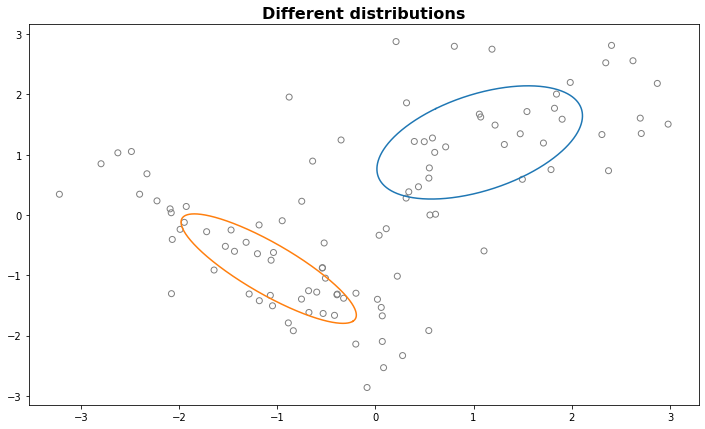

In [16]:
eigenvalues0, eigenvectors0 = np.linalg.eig(sigma0[0])
eigenvalues1, eigenvectors1 = np.linalg.eig(sigma0[1])

theta = np.linspace(0, 2 * np.pi, 1000)
ellipsis0 = (np.sqrt(eigenvalues0[None,:]) * eigenvectors0) @ [np.sin(theta), np.cos(theta)]
ellipsis1 = (np.sqrt(eigenvalues1[None,:]) * eigenvectors1) @ [np.sin(theta), np.cos(theta)]

# Plot the information
fig, ax = plt.subplots(figsize=(12,7))
plt.title("Different distributions", fontweight="bold", size=16)
plt.plot(ellipsis0[0,:]+mu0[0][0], ellipsis0[1,:]+mu0[0][1])
plt.plot(ellipsis1[0,:]+mu0[1][0], ellipsis1[1,:]+mu0[1][1])
ax.scatter(C[:,0], C[:,1], marker='o', facecolors='none', color='gray')